In [1]:
# import
import os, sys, glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import distance
from tqdm import tqdm
from sklearn.decomposition import PCA

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot
from snaplab_tools.plotting.utils import get_my_colors
from snaplab_tools.derivs import compute_acf

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

subjects_file = os.path.join(indir, 'HCPYA_{0}_subjids.txt'.format(atlas))
subject_ids = np.loadtxt(subjects_file, dtype=int)
n_subs = len(subject_ids)
print(n_subs)

A_file = os.path.join(indir, 'HCPYA_{0}_A.npy'.format(atlas))
adjacency = np.load(A_file)
n_nodes = adjacency.shape[0]
print(adjacency.shape)

rsts = np.load(os.path.join(indir, '{0}_{1}_rsts.npy'.format(which_data, atlas)))
n_scans = rsts.shape[2]
timescales = np.zeros((n_nodes, n_scans, n_subs))
for i in tqdm(np.arange(n_subs)):
    for j in np.arange(n_scans):
        for k in np.arange(n_nodes):
            try:
                _, timescales[k, j, i] = compute_acf(rsts[:, k, j, i])
            except:
                timescales[k, j, i] = np.nan
timescales = timescales[:, 0, :]
timescales_mean = np.nanmean(timescales, axis=1)
print(timescales.shape, timescales_mean.shape)

960
(400, 400, 960)


100%|██████████| 960/960 [00:29<00:00, 32.25it/s]

(400, 960) (400,)


In [3]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

n_states = 7

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

In [4]:
adjacency_weights = np.zeros((n_states, n_states, n_nodes, n_subs))

for i in tqdm(np.arange(n_subs)):
    file_str = 'HCPYA-{0}-adj-{1}_optimal-optimized-energy_k-{2}_c-{3}_T-{4}_rho-{5}_refstate-{6}_initweights-{7}_nsteps-{8}_lr-{9}_eigweight-{10}_regweight-{11}_regtype-{12}'.format(atlas,  i, 
                                                                                                                                                                                       n_states, 
                                                                                                                                                                                       c, time_horizon, rho,
                                                                                                                                                                                       reference_state, init_weights,
                                                                                                                                                                                       n_steps, lr, eig_weight, reg_weight, reg_type)
    log_args = np.load(os.path.join(outdir, 'subjects', file_str + '.npy'), allow_pickle=True).item()
    
    adjacency_weights[:, :, :, i] = -0 - log_args['optimized_weights']

print(adjacency_weights.shape)

100%|██████████| 960/960 [00:00<00:00, 4314.08it/s]

(7, 7, 400, 960)


In [5]:
# load rsfMRI clusters
k = n_states
fmri_clusters_file = '{0}_{1}_rsts_fmri_clusters_k-{2}.npy'.format(which_data, atlas, k)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())

centroids = fmri_clusters['centroids']
cluster_labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_transitions = n_states * n_states

print('n_states, {0}; n_nodes, {1}'.format(n_states, n_nodes))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_nodes, 400


In [6]:
fmri_concat_subjidx_file = '{0}_{1}_rsts_fmri_clusters_fmri_concat_subjidx.npy'.format(which_data, atlas)
fmri_concat_subjidx = np.load(os.path.join(outdir, fmri_concat_subjidx_file))[:, 0]
print(cluster_labels.shape, fmri_concat_subjidx.shape)

(1152000,) (1152000,)


# Optimized decay rates

In [7]:
corr_weights_timescales = np.zeros((n_states, n_states, n_subs))
for i in tqdm(np.arange(n_subs)):
    for init_state in np.arange(n_states):
        for targ_state in np.arange(n_states):
            if init_state != targ_state:
                corr_weights_timescales[init_state, targ_state, i] = sp.stats.pearsonr(adjacency_weights[init_state, targ_state, :, i], timescales[:, i])[0]
                # corr_weights_timescales[init_state, targ_state, i] = sp.stats.spearmanr(adjacency_weights[init_state, targ_state, :, i], timescales[:, i])[0]
            else:
                corr_weights_timescales[init_state, targ_state, i] = np.nan
            
corr_weights_timescales.shape

100%|██████████| 960/960 [00:12<00:00, 79.90it/s]


(7, 7, 960)

In [8]:
def compute_transition_probabilities(cluster_labels, n_states):
    n_frames = len(cluster_labels)

    transition_prob = np.zeros((n_states, n_states))
    for init_state in np.arange(n_states):
        init_state_loc = np.where(cluster_labels == init_state)[0]
        
        if n_frames - 1 in init_state_loc:
            init_state_loc = np.delete(init_state_loc, np.where(init_state_loc == n_frames - 1)[0])
        
        next_frame = cluster_labels[init_state_loc + 1]
        # next_frame = np.delete(next_frame, np.where(next_frame == init_state)[0])
        for targ_state in np.arange(n_states):
            transition_prob[init_state, targ_state] = np.sum(next_frame == targ_state) / len(next_frame)
            # transition_prob[init_state, targ_state] = np.sum(next_frame == targ_state)
    transition_prob[np.eye(n_states) == 1] = np.nan

    return transition_prob

In [9]:
transition_prob = np.zeros((n_states, n_states, n_subs))

for i in tqdm(np.arange(n_subs)):
    subjidx_mask = fmri_concat_subjidx == i
    transition_prob[:, :, i] = compute_transition_probabilities(cluster_labels[subjidx_mask], n_states)

100%|██████████| 960/960 [00:00<00:00, 2800.26it/s]


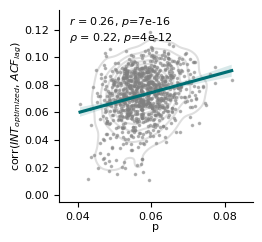

In [10]:
mask = np.eye(n_states) == 0
f, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
reg_plot(transition_prob[mask].mean(axis=0), corr_weights_timescales[mask].mean(axis=0), xlabel='p', ylabel='corr($INT_{optimized}$, $ACF_{lag}$)', ax=ax, annotate='both')
f.savefig(os.path.join(outdir, "corr_transition_prob_ints_coupling.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)

100%|██████████| 960/960 [00:00<00:00, 4595.36it/s]

TtestResult(statistic=9.918484584951516, pvalue=3.8567639500910586e-22, df=959)


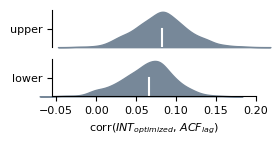

In [11]:
my_colors = get_my_colors(cat_trio=True, as_list=True)

my_df = pd.DataFrame(index=subject_ids)

for i in tqdm(np.arange(n_subs)):
    my_thresh = np.quantile(transition_prob[mask][:, i], 0.5)
    transition_prob_upper = transition_prob[mask][:, i] > my_thresh
    transition_prob_lower = transition_prob[mask][:, i] < my_thresh

    my_df.loc[subject_ids[i], 'upper'] = np.mean(corr_weights_timescales[mask][transition_prob_upper, i])
    my_df.loc[subject_ids[i], 'lower'] = np.mean(corr_weights_timescales[mask][transition_prob_lower, i])
    
print(sp.stats.ttest_rel(my_df['upper'], my_df['lower']))

my_df = my_df.melt()
my_df.rename(columns={'value': 'corr($INT_{optimized}$, $ACF_{lag}$)'}, inplace=True)
fig, axes = categorical_kde_plot(df=my_df, variable='corr($INT_{optimized}$, $ACF_{lag}$)',
                                 category='variable', horizontal=True, rug=False, fig_width=2.7, fig_height=1.5)
for ax in axes:
    ax.set_xlim([-0.055, .2])
plt.show()
fig.savefig(os.path.join(outdir, "corr_transition_prob_ints_coupling_split.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)